<a href="https://colab.research.google.com/github/JaradAng/tensorflow_training/blob/main/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
Using the Keras Functional API (a differnt way to build models in Keras)
Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
Data augmentation (how to make your training dataset more diverse without adding more data)
Running a series of modelling experiments on our Food Vision data
Model 0: a transfer learning model using the Keras Functional API
Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
Model 3: a fine-tuned transfer learning model on 10% of the data
Model 4: a fine-tuned transfer learning model on 100% of the data
Introduce the ModelCheckpoint callback to save intermediate training results
Compare model experiments results using TensorBoard

In [1]:
#bringing in the helper functions to save time
!wget https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py

--2022-12-12 19:50:55--  https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2022-12-12 19:50:55 (45.9 MB/s) - ‘helper_functions.py’ saved [10234/10234]



In [2]:
#importing them to notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
#bringing in the data and this time seeing how to use pretrained models within tf.keras.applications
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2022-12-12 19:51:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.8MB/s    in 7.9s    

2022-12-12 19:51:10 (20.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#checking out num of images and subdirs
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# creating the test and train paths
train_dir = '/content/10_food_classes_10_percent/train'

test_dir = '/content/10_food_classes_10_percent/test'

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = 'categorical',
                                                                           batch_size = BATCH_SIZE)                         

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
#checking type of train
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
#checking out class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
#see an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)


tf.Tensor(
[[[[148.69388   168.69388   175.69388  ]
   [132.80103   151.80103   158.80103  ]
   [139.40816   155.7653    166.40816  ]
   ...
   [182.77045   186.19897   192.98471  ]
   [183.52548   183.52548   191.52548  ]
   [177.98447   177.98447   185.98447  ]]

  [[149.0153    169.0153    178.0153   ]
   [136.77551   155.05103   164.91327  ]
   [159.43367   175.7347    186.54591  ]
   ...
   [177.41342   180.57156   189.73993  ]
   [181.86736   184.80104   194.00002  ]
   [184.28554   184.28554   194.37737  ]]

  [[154.02551   175.59694   186.16837  ]
   [155.92856   176.04082   186.61224  ]
   [161.90306   179.04593   193.       ]
   ...
   [168.59709   172.76541   184.29095  ]
   [171.52559   173.5409    186.22455  ]
   [179.99475   181.56618   193.91818  ]]

  ...

  [[  7.061227    4.9234924  26.352037 ]
   [ 18.80104     4.9286156  10.397991 ]
   [ 60.045925   26.500029    9.142876 ]
   ...
   [ 46.571472   46.974503   67.051056 ]
   [ 55.92862    53.91331    67.69898  ]
   [ 

Model 0: Building a transfer learning model using the Keras Functional API
Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

Instantiate a pre-trained base model object by choosing a target model such as EfficientNetB0 from tf.keras.applications, setting the include_top parameter to False (we do this because we're going to create our own top, which are the output layers for the model).
Set the base model's trainable attribute to False to freeze all of the weights in the pre-trained model.
Define an input layer for our model, for example, what shape of data should our model expect?
[Optional] Normalize the inputs to our model if it requires. Some computer vision models such as ResNetV250 require their inputs to be between 0 & 1.
🤔 Note: As of writing, the EfficientNet models in the tf.keras.applications module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted an issue to the TensorFlow GitHub about this and they confirmed this.

Pass the inputs to the base model.
Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using tf.keras.layers.GlobalAveragePooling2D() or tf.keras.layers.GlobalMaxPooling2D() though the former is more common in practice.
Create an output activation layer using tf.keras.layers.Dense() with the appropriate activation function and number of neurons.
Combine the inputs and outputs layer into a model using tf.keras.Model().
Compile the model using the appropriate loss function and choose of optimizer.
Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).
Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [10]:
 #writing a functional api model and transfer learning
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

 #. Freeze base
base_model.trainable = False

 #Create the inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name = 'input_layer')

 #4. If using model like resnet50v2 - will need to normalize input not for efficient net
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)

 #5. pass the inputs to the base model
x=base_model(inputs)
print(f'shape after passing through basemodel {x.shape}')

 #6. Average pool of outputs of the base model to reduce computations
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'the shape after global pooling is: {x.shape}')


#7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(x)

#8. combine input and output into a model
model_0 = tf.keras.Model(inputs, outputs)



16705208/16705208 [==============================] - 2s 0us/step
shape after passing through basemodel (None, 7, 7, 1280)
the shape after global pooling is: (None, 1280)


In [11]:
#compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer ='Adam',
                metrics=['accuracy'])



In [14]:
#fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch= len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks = [create_tensorboard_callback("transfer_learning",
                                                                '10_percent_feature_extraction')])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221212-195442
Epoch 1/5
24/24 [==============================] - 13s 520ms/step - loss: 0.4763 - accuracy: 0.8920 - val_loss: 0.5132 - val_accuracy: 0.8676
Epoch 2/5
24/24 [==============================] - 8s 318ms/step - loss: 0.4299 - accuracy: 0.9080 - val_loss: 0.4857 - val_accuracy: 0.8724
Epoch 3/5
24/24 [==============================] - 8s 317ms/step - loss: 0.3820 - accuracy: 0.9280 - val_loss: 0.4657 - val_accuracy: 0.8744
Epoch 4/5
24/24 [==============================] - 8s 319ms/step - loss: 0.3474 - accuracy: 0.9347 - val_loss: 0.4483 - val_accuracy: 0.8784
Epoch 5/5
24/24 [==============================] - 8s 320ms/step - loss: 0.3109 - accuracy: 0.9467 - val_loss: 0.4383 - val_accuracy: 0.8776


In [15]:
#evaulate
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4383 - accuracy: 0.8776


[0.4383108913898468, 0.8776000142097473]

In [17]:
#check the layers in base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [19]:
#summary 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [20]:
#summary of whole modle
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


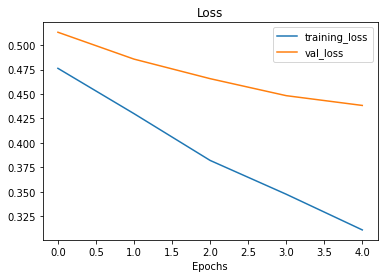

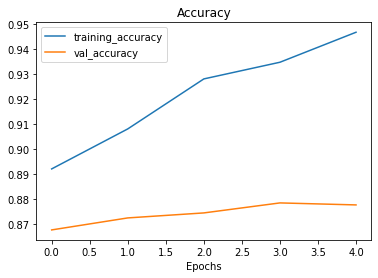

In [21]:
#plot the loss curve
plot_loss_curves(history_0)